In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import random
from joblib import dump, load
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
f = open('calibration.pckl','rb')
stereoMap_L, projMatrix_L, stereoMap_R, projMatrix_R = pickle.load(f)
f.close()

lda = load('lda.joblib')

C:\Users\maxfi\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator LinearDiscriminantAnalysis from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


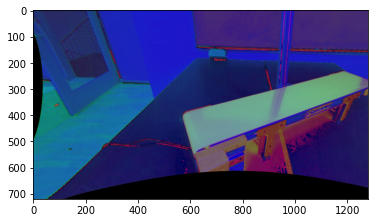

In [3]:
# median/background
imagesLeft = glob.glob('Stereo_conveyor_without_occlusions/left/*.png')
i = 0
frames = []
for imgLeft in imagesLeft:
    r_k = random.randint(0,len(imagesLeft)-1)
    img_ref = cv2.imread(imagesLeft[r_k])
    res_ref = cv2.remap(img_ref, stereoMap_L[0], stereoMap_L[1], cv2.INTER_LINEAR)
    frames.append(res_ref)
    i = i + 1
    if i > 300:
        break
    
bg_L = np.median(frames,axis=0).astype(dtype=np.uint8)
bg_L = cv2.cvtColor(bg_L,cv2.COLOR_BGR2HSV)
plt.imshow(bg_L)

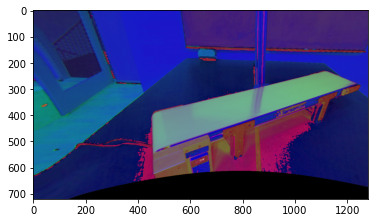

In [4]:
# median/background
imagesRight = glob.glob('Stereo_conveyor_without_occlusions/right/*.png')
i = 0
frames = []
for imgRight in imagesRight:
    r_k = random.randint(0,len(imagesRight)-1)
    img_ref = cv2.imread(imagesRight[r_k])
    res_ref = cv2.remap(img_ref, stereoMap_R[0], stereoMap_R[1], cv2.INTER_LINEAR)
    frames.append(res_ref)
    i = i + 1
    if i > 300:
        break
    
bg_R = np.median(frames,axis=0).astype(dtype=np.uint8)
bg_R = cv2.cvtColor(bg_R,cv2.COLOR_BGR2HSV)
plt.imshow(bg_R)

In [5]:
# Kalman Filter
def kalman_init():
    x = np.array([[1200], # Position along the x-axis
              [0], # Velocity along the x-axis
              [250], # Position along the y-axis
              [0]])

    # The initial uncertainty (6x6).
    P = np.array([[10, 0, 0, 0],
              [0, 10, 0, 0],
              [0, 0, 10, 0],
              [0, 0, 0, 10]])
    
    return x,P

def update(x, P, Z, H, R, I):
    ### Insert update function
    y = Z-np.dot(H,x)
    S = np.dot(np.dot(H,P),H.T)+R
    K = np.dot(np.dot(P,H.T),np.linalg.pinv(S))
    x_u = x+np.dot(K,y)
    p_u = np.dot((I-np.dot(K,H)),P)
    return [x_u, p_u]

def predict(x, P, F, u):
    ### insert predict function
    x_p = np.dot(F,x) + u
    p_p = np.dot(np.dot(F,P),F.T)
    return [x_p, p_p]

# The external motion. Set to 0 here.
# Wtih no occlusion
u = np.array([[0],[-0.03],[0],[0.009]])
# With occlusion
# u = np.array([[0],[-0.05],[0],[0.017]])

# The transition matrix. 
F = np.array([[1, 1, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 1],
              [0, 0, 0, 1]])

# The observation matrix. We only get the position as measurement.
H = np.array([[1, 0, 0, 0],
              [0, 0, 1, 0]])

# The measurement uncertainty
R = np.array([[0.01, 0],
              [0, 0.01]])

# The identity matrix. Simply a matrix with 1 in the diagonal and 0 elsewhere.
I = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])

In [6]:
def imsum_morph(im1,im2,im3,im4,im5,im6,im7,im8,rec,inspace,cX,cY,left):
    topleft, botright = (0, 0), (0, 0)
    
    imsum = cv2.add(cv2.add(cv2.add(cv2.add(cv2.add(cv2.add(cv2.add(im1,im2),im3),im4),im5),im6),im7),im8)
    imsum = cv2.GaussianBlur(imsum, kernel, 0)
    imsum = cv2.cvtColor(imsum,cv2.COLOR_BGR2GRAY)
    ret,imsum = cv2.threshold(imsum,190,255,cv2.THRESH_BINARY)
    imsum = cv2.erode(imsum, None, iterations = 10)
    imsum = cv2.dilate(imsum, None, iterations = 55)
    if (left == 1):
        imsum[575::,:] = 0
        imsum[:,0:550] = 0
    else:
        imsum[575::,:] = 0
        imsum[:,0:400] = 0

    contours = cv2.findContours(imsum,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)[0]
    if len(contours) > 0:
        #topleft = (np.min(contours[0][:,0][:,0]),np.min(contours[0][:,0][:,1]))
        #botright = (np.max(contours[0][:,0][:,0]),np.max(contours[0][:,0][:,1]))
        #cv2.rectangle(rec,topleft,botright,(0,255,0),3)
        for c in contours:
            # calculate moments for each contour
            M = cv2.moments(c)
            # calculate x,y coordinate of center
            if M["m00"] == 0:
                continue
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            
            if (left == 1):
                if (675 < cX) and (cX < 1250):
                    #cv2.circle(rec, (cX, cY), 5, (255, 0, 0), -1)
                    inspace = 1
                    topleft = (np.min(c[:,0][:,0]),np.min(c[:,0][:,1]))
                    botright = (np.max(c[:,0][:,0]),np.max(c[:,0][:,1]))
                else:
                    inspace = 0
            else:
                if (530 < cX) and (cX < 1170):
                    #cv2.circle(rec, (cX, cY), 5, (255, 0, 0), -1)
                    inspace = 1
                    topleft = (np.min(c[:,0][:,0]),np.min(c[:,0][:,1]))
                    botright = (np.max(c[:,0][:,0]),np.max(c[:,0][:,1]))
                else:
                    inspace = 0
    else:
        cX, cY = 0,0
        topleft, botright = (0,0), (0,0)
    

    
    result = cv2.bitwise_and(rec,rec, mask = imsum)
    
    return result, rec, cX, cY, inspace, topleft, botright

In [7]:
def detlength (current,prev):

    if (current >= prev):
        length = current
    elif (current < prev):
        length = prev
         
    return length

def checkprev(left,right,top,bot,leftp,rightp,topp,botp):
    
    left = detlength(left,leftp)
    right = detlength(right,rightp)
    top = detlength(top,topp)
    bot = detlength(bot,botp)
    
    if (top >= bot):
        bot = top
    elif (bot < top):
        top = bot
        
    thresh = 250
    if (left > thresh) or (right > thresh) or (top > thresh) or (bot > thresh):
        left, right, top, bot = 0, 0, 0, 0
        
    return left, right, top, bot

In [9]:
# load classification model and itit queue (only once)
label_name = {0:'book', 1:'box', 2:'cup'}
class_text = ""

im1L, im2L, im3L, im4L, im5L, im6L, im7L, im8L = 0, 0, 0, 0, 0, 0, 0, 0
im1R, im2R, im3R, im4R, im5R, im6R, im7R, im8R = 0, 0, 0, 0, 0, 0, 0, 0
distleftL, distrightL, disttopL, distbotL = 0, 0, 0, 0
distleftR, distrightR, disttopR, distbotR = 0, 0, 0, 0

kernel = (71,71)
inspaceL, inspaceR = 0, 0
pdictL, pdictR = 0, 0
i = 0
cXL, cYL, cXR, cYR = 0, 0, 0, 0
for imgLeft, imgRight in zip(imagesLeft,imagesRight):
    
    dlLp, drLp, dtLp, dbLp = distleftL, distrightL, disttopL, distbotL
    dlRp, drRp, dtRp, dbRp = distleftR, distrightR, disttopR, distbotR
    
    rec_left = cv2.remap(cv2.imread(imgLeft), stereoMap_L[0], stereoMap_L[1], cv2.INTER_LINEAR)
    boxedL = rec_left.copy()
    rec_right = cv2.remap(cv2.imread(imgRight), stereoMap_R[0], stereoMap_R[1], cv2.INTER_LINEAR)
    boxedR = rec_right.copy()
    
    if i < 8:
        im8L, im7L, im6L, im5L, im4L, im3L, im2L = im7L, im6L, im5L, im4L, im3L, im2L, im1L
        im1L = cv2.absdiff(cv2.cvtColor(rec_left,cv2.COLOR_BGR2HSV),bg_L)
        im8R, im7R, im6R, im5R, im4R, im3R, im2R = im7R, im6R, im5R, im4R, im3R, im2R, im1R
        im1R = cv2.absdiff(cv2.cvtColor(rec_right,cv2.COLOR_BGR2HSV),bg_R)
        i = i + 1
        continue
    
    im8L, im7L, im6L, im5L, im4L, im3L, im2L = im7L, im6L, im5L, im4L, im3L, im2L, im1L
    im1L = cv2.absdiff(cv2.cvtColor(rec_left,cv2.COLOR_BGR2HSV),bg_L)
    im8R, im7R, im6R, im5R, im4R, im3R, im2R = im7R, im6R, im5R, im4R, im3R, im2R, im1R
    im1R = cv2.absdiff(cv2.cvtColor(rec_right,cv2.COLOR_BGR2HSV),bg_R)

    i = i + 1
    #if i>190:
    #    break
       
    resultL, rec_left, cXL, cYL, inspaceL, topleftL, botrightL = imsum_morph(im1L, im2L, im3L, im4L, im5L, im6L, im7L, im8L,rec_left,inspaceL,cXL,cYL,1)
    resultR, rec_right, cXR, cYR, inspaceR, topleftR, botrightR = imsum_morph(im1R, im2R, im3R, im4R, im5R, im6R, im7R, im8R,rec_right,inspaceR,cXR,cYR,0) 
    
    blobareaL = (botrightL[0]-topleftL[0])*(botrightL[1]-topleftL[1])
    blobareaR = (botrightR[0]-topleftR[0])*(botrightR[1]-topleftR[1])
    
    distleftL, distrightL, disttopL, distbotL = abs(cXL-topleftL[0]), abs(cXL-botrightL[0]), abs(cYL-topleftL[1]), abs(cYL-botrightL[1])
    distleftR, distrightR, disttopR, distbotR = abs(cXR-topleftR[0]), abs(cXR-botrightR[0]), abs(cYR-topleftR[1]), abs(cYR-botrightR[1])
    
    distleftL, distrightL, disttopL, distbotL = checkprev(distleftL, distrightL, disttopL, distbotL, dlLp, drLp, dtLp, dbLp)
    distleftR, distrightR, disttopR, distbotR = checkprev(distleftR, distrightR, disttopR, distbotR, dlRp, drRp, dtRp, dbRp)
    
    boxareaL = (disttopL + distbotL)*(distleftL + distrightL)
    boxareaR = (disttopR + distbotR)*(distleftR + distrightR)
    
    checkboth = 0
    
    if (inspaceL == 0):
        x,P = kalman_init()
        distleftL, distrightL, disttopL, distbotL = 0, 0, 0, 0
        tlL = (0,0)
    else:
        checkboth = checkboth + 1
        if ((cXL == 0) and (cYL == 0)):
        #if ((cXL == 0) and (cYL == 0)) or (blobareaL < boxareaL*0.65):
            x, P = predict(x,P,F,u)
            cv2.circle(rec_left, (int(x[0]), int(x[2])), 3, (0, 0, 255), -1)
            pdictL = 1
        else:
            if (pdictL == 1):
                distleftL, distrightL, disttopL, distbotL = 0, 0, 0, 0
                pdictL = 0
            
            Z = np.array([[cXL],
                          [cYL]])
            
            x_u, p_u = update(x, P, Z, H, R, I)
            x, P = predict(x_u,p_u,F,u)
            cv2.circle(rec_left, (int(x[0]), int(x[2])), 3, (0, 255, 0), -1)
            
        if (int(x[0]+distrightL)>=1280):
            rightsideL = 1280
        else:
            rightsideL = int(x[0]+distrightL)
        
        tlL, brL = (int(x[0]-distleftL*1.1),int(x[2]-disttopL*1.1)), (rightsideL,int(x[2])+distbotL)
        cv2.rectangle(rec_left,tlL,brL,(0,255,0),3)
    
    if (inspaceR == 0):
        xR,PR = kalman_init()
        distleftR, distrightR, disttopR, distbotR = 0, 0, 0, 0
        tlR = (0,0)
        queue = []
        class_text = ""
    else:
        checkboth = checkboth + 1
        if ((cXR == 0) and (cYR == 0)):
        #if ((cXR == 0) and (cYR == 0)) or (blobareaR < boxareaR*0.6):
            xR, PR = predict(xR,PR,F,u)
            cv2.circle(rec_right, (int(xR[0]), int(xR[2])), 3, (0, 0, 255), -1)
            pdictR = 1
        else:
            if (pdictR == 1):
                distleftR, distrightR, disttopR, distbotR = 0, 0, 0, 0
                pdictR = 0
                
            ZR = np.array([[cXR],
                          [cYR]])

            x_uR, p_uR = update(xR, PR, ZR, H, R, I)
            xR, PR = predict(x_uR,p_uR,F,u)
            cv2.circle(rec_right, (int(xR[0]), int(xR[2])), 3, (0, 255, 0), -1)
            
            if (tlR != (0,0)) and (tlR[0]-brR[0] != 0) and (pdictR == 0):
                boxedR = boxedR[tlR[1]:brR[1],tlR[0]:brR[0]]

                # preprocess each frame
                imageSize = (128,128)
                img = cv2.resize(boxedR, imageSize)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                edged = cv2.Canny(gray, 10, 150)

                # predict on preprocessed input
                if len(queue) < 14:
                    ml_input = edged.reshape(1, -1)
                    predicted = lda.predict(ml_input)
                    queue.append(predicted)

                # queue to decrease pred noise
                #if len(queue) > 12:
                #    queue.pop(0)
                occ = [queue.count(0), queue.count(1), queue.count(2)]
                predicted = occ.index(max(occ)) # string in {book, box, cup}
                class_text = label_name[predicted]
                
            else:
                boxedR = 0
            
        if (int(xR[0]+distrightR)>=1280):
            rightsideR = 1280
        else:
            rightsideR = int(xR[0]+distrightR)
        
        tlR, brR = (int(xR[0]-distleftR*1.2),int(xR[2]-disttopR*1.2)), (rightsideR,int(xR[2])+distbotR)
        cv2.rectangle(rec_right,tlR,brR,(0,255,0),3)
            
    if (checkboth == 2):
        triang = cv2.triangulatePoints(projMatrix_L,projMatrix_R,x[::2],xR[::2])
        triang = triang/triang[3]
        text = "Object Location: x ={0:02f} y = {1:02f} z = {2:02f}".format(float(triang[0]), float(triang[1]),float(triang[2]))
    else:
        text = "No Object"
    
    textR = text
    cv2.putText(rec_left,text, (10, 50), cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 1, 8);
    cv2.putText(rec_right,textR, (10, 50), cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 1, 8);  
    cv2.putText(rec_right,class_text, tlR, cv2.FONT_HERSHEY_PLAIN, 3, (0, 0, 255), 1, 8); 
        
    if (tlL != (0,0)) and (tlL[0]-brL[0] != 0) and (pdictL == 0):
        boxedL = boxedL[tlL[1]:brL[1],tlL[0]:brL[0]]
    else:
        boxedL = 0
        
    #cv2.imshow('boxedL',boxedL)
    #cv2.imshow('boxedR',boxedR)
    
    #rec_left = cv2.resize(rec_left, (480, 270))
    #cv2.imshow('imgL',rec_left)
    
    #rec_right = cv2.resize(rec_right, (480, 270))
    cv2.imshow('imgR',rec_right)
    
    cv2.waitKey(10)
    
cv2.destroyAllWindows()